In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

import datetime as dt

In [4]:
def pressure_to_depth(p,latitude):
    '''
    Convert pressure to depth based on Seabirds equation:
    http://www.seabird.com/document/an69-conversion-pressure-depth
    First, it corrects gravitational acceleration for the latitude
    Then caluclates the depth from the pressure, assuming 35 PSU and zero degress C
    '''
    
    x = np.sin(np.deg2rad(latitude/57.29578))**2 
    g = 9.780318 * ( 1.0 + ( 5.2788e-3  + 2.36e-5  * x) * x ) + 1.092e-6  * p
    return ((((-1.82e-15 * p + 2.279e-10 ) * p - 2.2512e-5 ) * p + 9.72659) * p) / g

argos = pd.read_csv('./example_data/ARGOS FLoats Peru.txt')

argos['Depth'] = pressure_to_depth(argos.Pressure,argos.Latitude) # Don't sure, instead, use the gibbs sea water package

tagday_min = dt.datetime(2014,11,21) - dt.timedelta(days=60)
tagday_max = dt.datetime(2014,11,21) + dt.timedelta(days=60)
argos.DateTime = pd.to_datetime(argos.DateTime)

#subset coastal floats 
sub = argos[(argos.DateTime > tagday_min) & (argos.DateTime < tagday_max)]
argos = sub
sub =  argos[argos.Longitude > -83]
argos = sub

stations = argos['Station'].unique()
print(f"There are {len(stations)} casts")
for st in stations:
    print(f"{st}")

There are 12 casts
24_R_A
25_R_A
26_R_A
27_R_A
28_R_A
29_R_A
30_R_A
31_R_A
32_R_A
33_R_A
34_R_A
35_R_A


__Plot all casts__

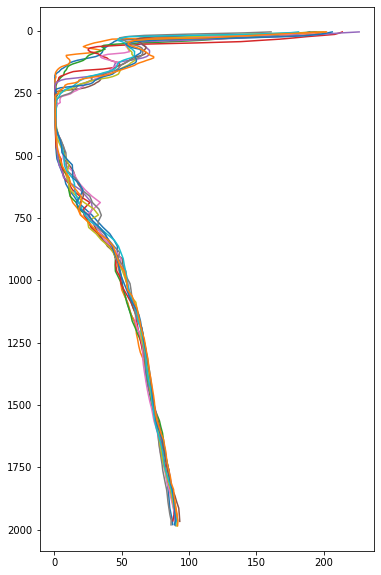

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(6,10)
ax.invert_yaxis()
for st in argos.Station.unique():
    temp = argos.query("Station == @st")
    ax.plot(temp["DO_kg_l"], temp['Pressure'])


__Calculate Mean and Standard Deviation of DO at each pressure bin__  
Not every cast uses the same pressure bins, so only select bins with five or more casts.


In [6]:
mean_depth = argos.groupby("Pressure").mean()
mean_depth['count'] = argos.groupby("Pressure").count()['DO_kg_l']
mean_depth['std'] = argos.groupby("Pressure").std()['DO_kg_l']

__Make the figure using the `fill_betweenx()` plotting function__

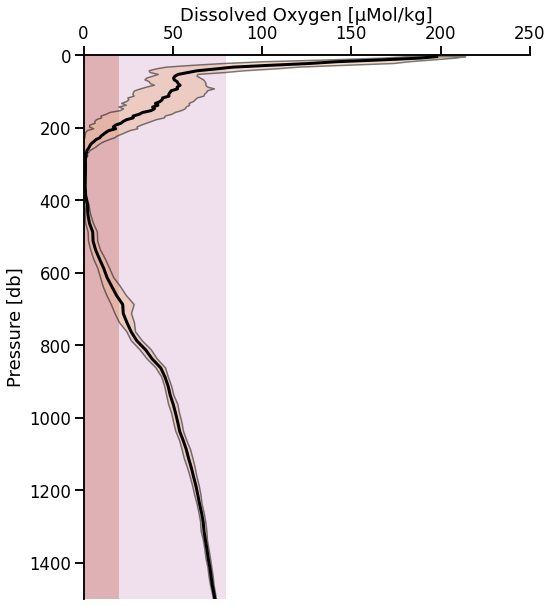

In [7]:
sns.set_context("talk")
fig, ax = plt.subplots()
fig.set_size_inches(8,10)

short = mean_depth.query("count > 5") # Don't plot a mean or STD of at depth bin with less than 5 data points
ax.fill_betweenx(short.index,  short["DO_kg_l"] - short["std"] , short["DO_kg_l"]+ short["std"],color='#EABA9A',alpha=.5, interpolate=True,edgecolor='k')
ax.plot(short["DO_kg_l"],short.index,c='k',lw=3)

ax.set_ylim(1500,0)
ax.set_xlim(-0,250)
ax.set_ylabel("Pressure [db]")
ax.xaxis.set_label_position('top')
ax.set_xlabel("Dissolved Oxygen [μMol/kg]")

ax.xaxis.tick_top()  # Move the x-axis ticks to the top
ax.yaxis.tick_left()  # Remove the right y-axis ticks

ax.spines['right'].set_visible(False)  # Remove the right spine
ax.spines['bottom'].set_visible(False)  # Remove the bottom spine


# Create a rectangle
rect = Rectangle((0,0), 20, 1500, facecolor='#DFB1B4',zorder=0)
ax.add_patch(rect)

rect = Rectangle((20,0), 60, 1500, facecolor='#F0DFEC',zorder=-10)
ax.add_patch(rect)

plt.savefig("Argos_floats.png",dpi=300, bbox_inches='tight')